# To do
- [x] apply correction as in RetinoMaps
- [x] simple timeseries x/y + space
- [x] create one figure per conditions of fixation
- [x] think about statistics to save across participant
- [x] save for all subjects

In [1]:
import sys
import os
import glob
import warnings
import numpy as np
import pandas as pd
from scipy.signal import detrend
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.ndimage import gaussian_filter1d
import plotly.io as pio
import plotly.express as px

In [32]:
# Define paths to functional data
main_dir = "/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye"
pred_dir = f"{main_dir}/pred"
fig_dir = f"{main_dir}/figures"

# Make directories
os.makedirs(fig_dir, exist_ok=True)

# Define settings
subjects = ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008']
sigma_smoothing = 3

In [33]:
for subject in subjects:
    pp_sub_dir = f"{pred_dir}/{subject}"
    eye_files = glob.glob(f"{pp_sub_dir}/*.tsv")
    for eye_file in eye_files:
        df = pd.read_csv(eye_file, sep='\t')

        print(eye_file)
        
        # linear detrending
        trend_x = np.polyfit(x=df.timestamps, y=df.x_coord, deg=1)
        trend_y = np.polyfit(x=df.timestamps, y=df.y_coord, deg=1)
        linear_trend_x = np.polyval(p=trend_x, x=df.timestamps)
        linear_trend_y = np.polyval(p=trend_y, x=df.timestamps)
        detrend_x = df.x_coord - linear_trend_x
        detrend_y = df.y_coord - linear_trend_y
        detrend_x += np.median(linear_trend_x)
        detrend_y += np.median(linear_trend_y)

        df['linear_trend_x'] = linear_trend_x
        
        df['x_coord_detrend'] = detrend_x
        df['y_coord_detrend'] = detrend_y

        # gaussian smoothing
        df['x_coord_detrend_gauss'] = gaussian_filter1d(df['x_coord_detrend'], sigma=sigma_smoothing)
        df['y_coord_detrend_gauss'] = gaussian_filter1d(df['y_coord_detrend'], sigma=sigma_smoothing)

        # get stats
        df['x_coord_detrend_gauss_mean'] = df['x_coord_detrend_gauss'].mean()
        df['y_coord_detrend_gauss_mean'] = df['y_coord_detrend_gauss'].mean()
        df['x_coord_detrend_gauss_std'] = df['x_coord_detrend_gauss'].std()
        df['y_coord_detrend_gauss_std'] = df['y_coord_detrend_gauss'].std()

         # plot 
        # fig = px.line(df, x='timestamps', y=['x_coord', 'y_coord', 'x_coord_detrend_gauss', 'y_coord_detrend_gauss'], title='x_coord vs Timestamp', 
        #               labels={'x_coord': 'X Coordinate', 'timestamps': 'Timestamp'})
        # fig.update_yaxes(range=[-5, 5])
        # fig.show()
        
        # Save the modified DataFrame back to the same file
        df.to_csv(eye_file, sep='\t', index=False)
        

/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-01_task-AttendStimGazeCenter_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-02_task-AttendStimGazeRight_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-01_task-AttendStimGazeLeft_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-01_task-AttendStimGazeCenterFS_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-01_task-AttendFixGazeCenter_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub-001/sub-001_ses-01_task-AttendFixGazeCenterFS_run-1_space-T1w_desc-preproc_bold.tsv
/home/mszinte/disks/meso_S/data/gaze_prf/derivatives/deepmreye/pred/sub

In [4]:
# # Settings
# y_range = [-5, 5]
# x_range = [-5, 5]
# base_color = (0, 150, 175)  # Turquoise
# row_titles = ["GazeCenterFS", "GazeCenter", "GazeLeft", "GazeRight"]

# for subject in subjects:
#     pp_sub_dir = f"{pred_dir}/{subject}"
    
#     fig = make_subplots(rows=4, cols=3, 
#                         vertical_spacing=0.1,  # Espacement vertical
#                         horizontal_spacing=0.11)  # Espacement horizontal
    
#     for row in range(1,5):
#         if row == 1: 
#             eye_files = glob.glob(f"{pp_sub_dir}/*GazeCenterFS*.tsv")
#         elif row == 2: 
#             eye_files = glob.glob(f"{pp_sub_dir}/*GazeCenter_*.tsv")
#         elif row == 3: 
#             eye_files = glob.glob(f"{pp_sub_dir}/*GazeLeft_*.tsv")
#         elif row == 4: 
#             eye_files = glob.glob(f"{pp_sub_dir}/*GazeRight_*.tsv")

    
#         for eye_file_num, eye_file in enumerate(eye_files):
    
#             # Define colors
#             opacity_values = np.linspace(0.2, 1, len(eye_files))
#             colors = [f'rgba({base_color[0]}, {base_color[1]}, {base_color[2]}, {opacity})' for opacity in opacity_values]
        
#             df = pd.read_csv(eye_file, sep='\t')
#             fig.add_trace(go.Scatter(x=df['timestamps'], y=df['x_coord_detrend_gauss'], mode='lines', 
#                                      line=dict(color=colors[eye_file_num])), row=row, col=1)
#             fig.add_trace(go.Scatter(x=df['timestamps'], y=df['y_coord_detrend_gauss'], mode='lines', 
#                                      line=dict(color=colors[eye_file_num])), row=row, col=2)
#             fig.add_trace(go.Scatter(x=df['x_coord_detrend_gauss_mean'],
#                                      y=df['y_coord_detrend_gauss_mean'],
#                                      mode='markers', marker=dict(color=colors[eye_file_num], size=7), 
#                                      error_x=dict(type='data', array=df['x_coord_detrend_gauss_std'], visible=True),
#                                      error_y=dict(type='data', array=df['y_coord_detrend_gauss_std'], visible=True)),
#                           row=row, col=3)
    
        
#             for i in range(1, 3): fig.update_yaxes(range=y_range, row=row, col=i, zeroline=True, zerolinecolor='black', zerolinewidth=1) 
#             fig.update_xaxes(range=x_range, row=row, col=3, zeroline=True, zerolinecolor='black', zerolinewidth=1)
#             fig.update_yaxes(range=y_range, row=row, col=3, zeroline=True, zerolinecolor='black', zerolinewidth=1)
            
#             # Set axis labels
#             fig.update_xaxes(title_text='Time (sec)', row=row, col=1) 
#             fig.update_xaxes(title_text='Time (sec)', row=row, col=2) 
#             fig.update_yaxes(title_text=f"{row_titles[row-1]} X coord. (dva)", row=row, col=1) 
#             fig.update_yaxes(title_text=f"{row_titles[row-1]} Y coord. (dva)", row=row, col=2) 
#             fig.update_xaxes(title_text=f"{row_titles[row-1]} X coord. (dva)", row=row, col=3) 
#             fig.update_yaxes(title_text=f"{row_titles[row-1]} Y coord. (dva)", row=row, col=3)
            
#     fig.update_layout(showlegend=False, width=1100, height=1400, template="simple_white",)

#     # Save figure
#     fig_sub_dir = f"{fig_dir}/{subject}"
#     os.makedirs(fig_sub_dir, exist_ok=True)
#     print(f"{fig_sub_dir}/{subject}_deepmreye.pdf")
#     pio.write_image(fig, f"{fig_sub_dir}/{subject}_deepmreye.pdf")

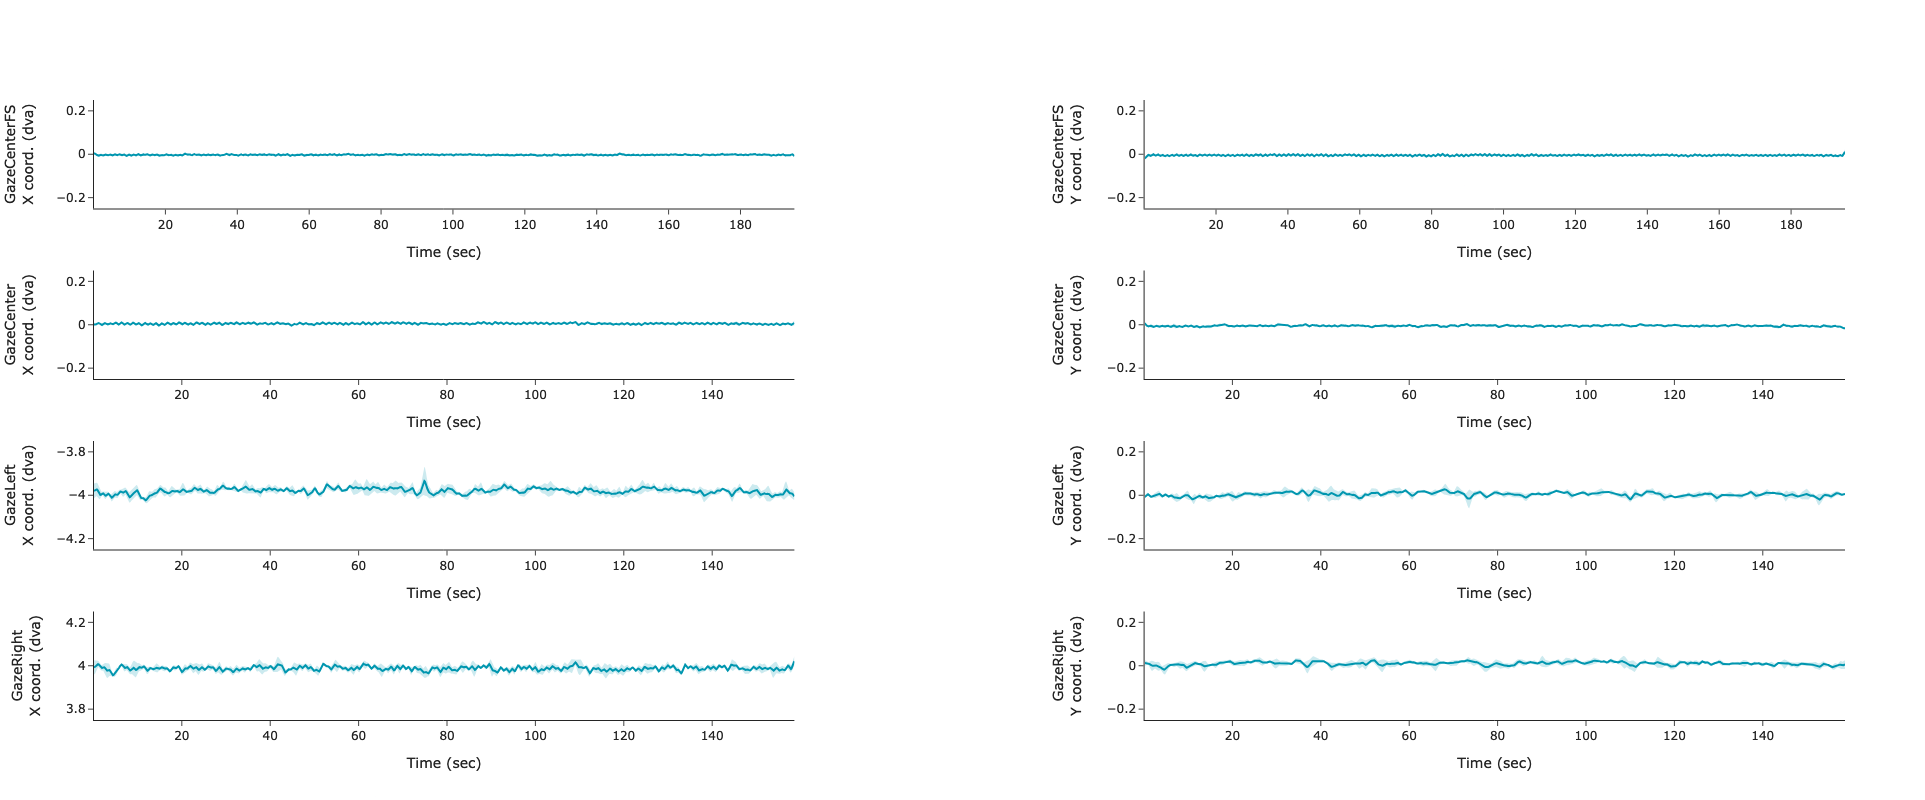

In [51]:
# Settings

base_color = 'rgb(0, 150, 175)'  # Turquoise
row_titles = ["GazeCenterFS", "GazeCenter", "GazeLeft", "GazeRight"]

for subject in subjects:
    pp_sub_dir = f"{pred_dir}/{subject}"
    
    fig = make_subplots(rows=4, cols=2, 
                        vertical_spacing=0.1,  # Espacement vertical
                        horizontal_spacing=0.2)  # Espacement horizontal
    
    for row in range(1, 5):
        if row == 1: 
            eye_files = glob.glob(f"{pp_sub_dir}/*GazeCenterFS*.tsv")
            y_range = [-0.25, 0.25]
            x_range = [-0.25, 0.25]
        elif row == 2: 
            eye_files = glob.glob(f"{pp_sub_dir}/*GazeCenter_*.tsv")
            y_range = [-0.25, 0.25]
            x_range = [-0.25, 0.25]
        elif row == 3: 
            eye_files = glob.glob(f"{pp_sub_dir}/*GazeLeft_*.tsv")
            y_range = [-0.25, 0.25]
            x_range = [-4.25, -3.75]
        elif row == 4: 
            eye_files = glob.glob(f"{pp_sub_dir}/*GazeRight_*.tsv")
            y_range = [-0.25, 0.25]
            x_range = [3.75, 4.25]

        # Loop through each eye file
        dfs = []
        for eye_file in eye_files:
            # Read the CSV file
            df = pd.read_csv(eye_file, sep='\t')
            dfs.append(df)

        # Concatenate all DataFrames along the rows
        mean_df = pd.concat(dfs).groupby(level=0).mean()
        std_df = pd.concat(dfs).groupby(level=0).std()

        # Reset index to keep the same shape (1500 rows x 14 columns)
        mean_df = mean_df.reset_index(drop=True)
        std_df = std_df.reset_index(drop=True)

        # Add mean traces
        fig.add_trace(go.Scatter(x=mean_df['timestamps'], y=mean_df['x_coord_detrend_gauss'], mode='lines', 
                                 line=dict(color=base_color)), row=row, col=1)
        fig.add_trace(go.Scatter(x=mean_df['timestamps'], y=mean_df['y_coord_detrend_gauss'], mode='lines', 
                                 line=dict(color=base_color)), row=row, col=2)

        # Add shaded areas for ± std
        fig.add_trace(go.Scatter(
            x=mean_df['timestamps'].tolist() + mean_df['timestamps'][::-1].tolist(),
            y=(mean_df['x_coord_detrend_gauss'] + std_df['x_coord_detrend_gauss']).tolist() + 
              (mean_df['x_coord_detrend_gauss'] - std_df['x_coord_detrend_gauss']).tolist()[::-1],
            fill='toself',
            fillcolor='rgba(0, 150, 175, 0.2)',  # Light turquoise
            line=dict(color='rgba(255,255,255,0)'),
            showlegend=False
        ), row=row, col=1)

        fig.add_trace(go.Scatter(
            x=mean_df['timestamps'].tolist() + mean_df['timestamps'][::-1].tolist(),
            y=(mean_df['y_coord_detrend_gauss'] + std_df['y_coord_detrend_gauss']).tolist() + 
              (mean_df['y_coord_detrend_gauss'] - std_df['y_coord_detrend_gauss']).tolist()[::-1],
            fill='toself',
            fillcolor='rgba(0, 150, 175, 0.2)',  # Light turquoise
            line=dict(color='rgba(255,255,255,0)'),
            showlegend=False
        ), row=row, col=2)

        for cols in range(1, 3):
            if cols == 1:
                y_range_plot = x_range                
            elif cols == 2:
                y_range_plot = y_range
            fig.update_yaxes(range=y_range_plot, row=row, col=cols, zeroline=False, zerolinecolor='black', zerolinewidth=1) 
    
        
        # Set axis labels
        fig.update_xaxes(title_text='Time (sec)', row=row, col=1) 
        fig.update_xaxes(title_text='Time (sec)', row=row, col=2) 
        fig.update_yaxes(title_text=f"{row_titles[row-1]}<br>X coord. (dva)", row=row, col=1) 
        fig.update_yaxes(title_text=f"{row_titles[row-1]}<br>Y coord. (dva)", row=row, col=2) 
            
    fig.update_layout(showlegend=False, width=800, height=800, template="simple_white",)

    # Save figure
    fig_sub_dir = f"{fig_dir}/{subject}"
    os.makedirs(fig_sub_dir, exist_ok=True)
    print(f"{fig_sub_dir}/{subject}_deepmreye_avg.pdf")
    pio.write_image(fig, f"{fig_sub_dir}/{subject}_deepmreye_avg.pdf")